In [71]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
plt.rcParams['legend.handlelength'] = 0

from utils import extract_cid_results, gen_conv_list, calc_time_av_ind_samples

from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [72]:
extract = True
calc_time_av = True
verbose = True
save_figs = True

nexp = 5
nbits = 4
cg = 4
output_suffix=f'_nb{nbits}cg{cg}'
uncertainty_multiplier = 20
act_exclude_dict = {512: [0.02, 0.0225], 1024: [], 2048: [0.0225]}

L_list = [512, 1024, 2048]
figs_save_path = f'data\\nematic\\figs\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): os.makedirs(figs_save_path )

act_dict = {}
cid_time_av_dict = {}
cid_shuffle_time_av_dict = {}
frac_time_av_dict = {}

for LX in L_list:

    base_path = f'Z:\\cid\\na{LX}'
    save_path = f'data\\nematic\\na{LX}'

    if not os.path.exists(save_path):
        os.makedirs(save_path )

    

    info_dict = {'base_path': base_path,
                'save_path': save_path,
                'output_suffix': output_suffix,
                'act_exclude_list': act_exclude_dict[LX],
                'LX': LX,
                'nexp': nexp,}

    if extract:
        conv_list = np.load(os.path.join(save_path, f'conv_list.npy'), allow_pickle=True)
        extract_cid_results(info_dict, verbose=True)
        gen_conv_list(conv_list, output_suffix, save_path)

    with open(os.path.join(save_path, f'cid_params{output_suffix}.pkl'), 'rb') as f:
                    cid_params = pkl.load(f)

    ncubes = cid_params['ncubes']
    npartitions = cid_params['npartitions']

    data_npz = np.load(os.path.join(save_path, f'cid_data{output_suffix}.npz'), allow_pickle=True)
    cid_arr = data_npz['cid']
    cid_shuffle_arr = data_npz['cid_shuffle']
    cid_frac_arr = data_npz['cid_frac']
    act_list = data_npz['act_list']
    conv_list = np.load(os.path.join(save_path, f'conv_list_cubes{output_suffix}.npy'), allow_pickle=True)

    if calc_time_av:
        cid_time_av = calc_time_av_ind_samples(cid_arr[:,:,:,:,0], conv_list, unc_multiplier=uncertainty_multiplier)
        cid_shuffle_time_av = calc_time_av_ind_samples(cid_shuffle_arr[:,:,:,:,0], conv_list, unc_multiplier=uncertainty_multiplier)
        cid_frac_time_av = calc_time_av_ind_samples(cid_frac_arr[:,:,:,:,0], conv_list, unc_multiplier=uncertainty_multiplier)

        np.savez_compressed(os.path.join(save_path, f'cid_time_av{output_suffix}.npz'),
                            cid_time_av=cid_time_av,
                            cid_shuffle_time_av=cid_shuffle_time_av,
                            cid_frac_time_av=cid_frac_time_av,
                            act_list=act_list,
                            )
    else:
        time_av_npz = np.load(os.path.join(save_path, f'cid_time_av{output_suffix}.npz'), allow_pickle=True)
        cid_time_av = time_av_npz['cid_time_av']
        cid_shuffle_time_av = time_av_npz['cid_shuffle_time_av']
        cid_frac_time_av = time_av_npz['cid_frac_time_av']
        act_list = time_av_npz['act_list']

    act_dict[LX] = act_list
    cid_time_av_dict[LX] = cid_time_av
    cid_shuffle_time_av_dict[LX] = cid_shuffle_time_av
    frac_time_av_dict[LX] = cid_frac_time_av

cid data saved to data\nematic\na512\cid_data_nb4cg4.npz
cid data saved to data\nematic\na1024\cid_data_nb4cg4.npz
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.07\zeta_0.07_counter_0, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.07\zeta_0.07_counter_1, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.07\zeta_0.07_counter_2, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.07\zeta_0.07_counter_3, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.07\zeta_0.07_counter_4, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_0, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_1, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_2, skipping...
cid_nb4cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_3, skipping...
cid_nb4cg4.npz not found in Z:\cid\na20

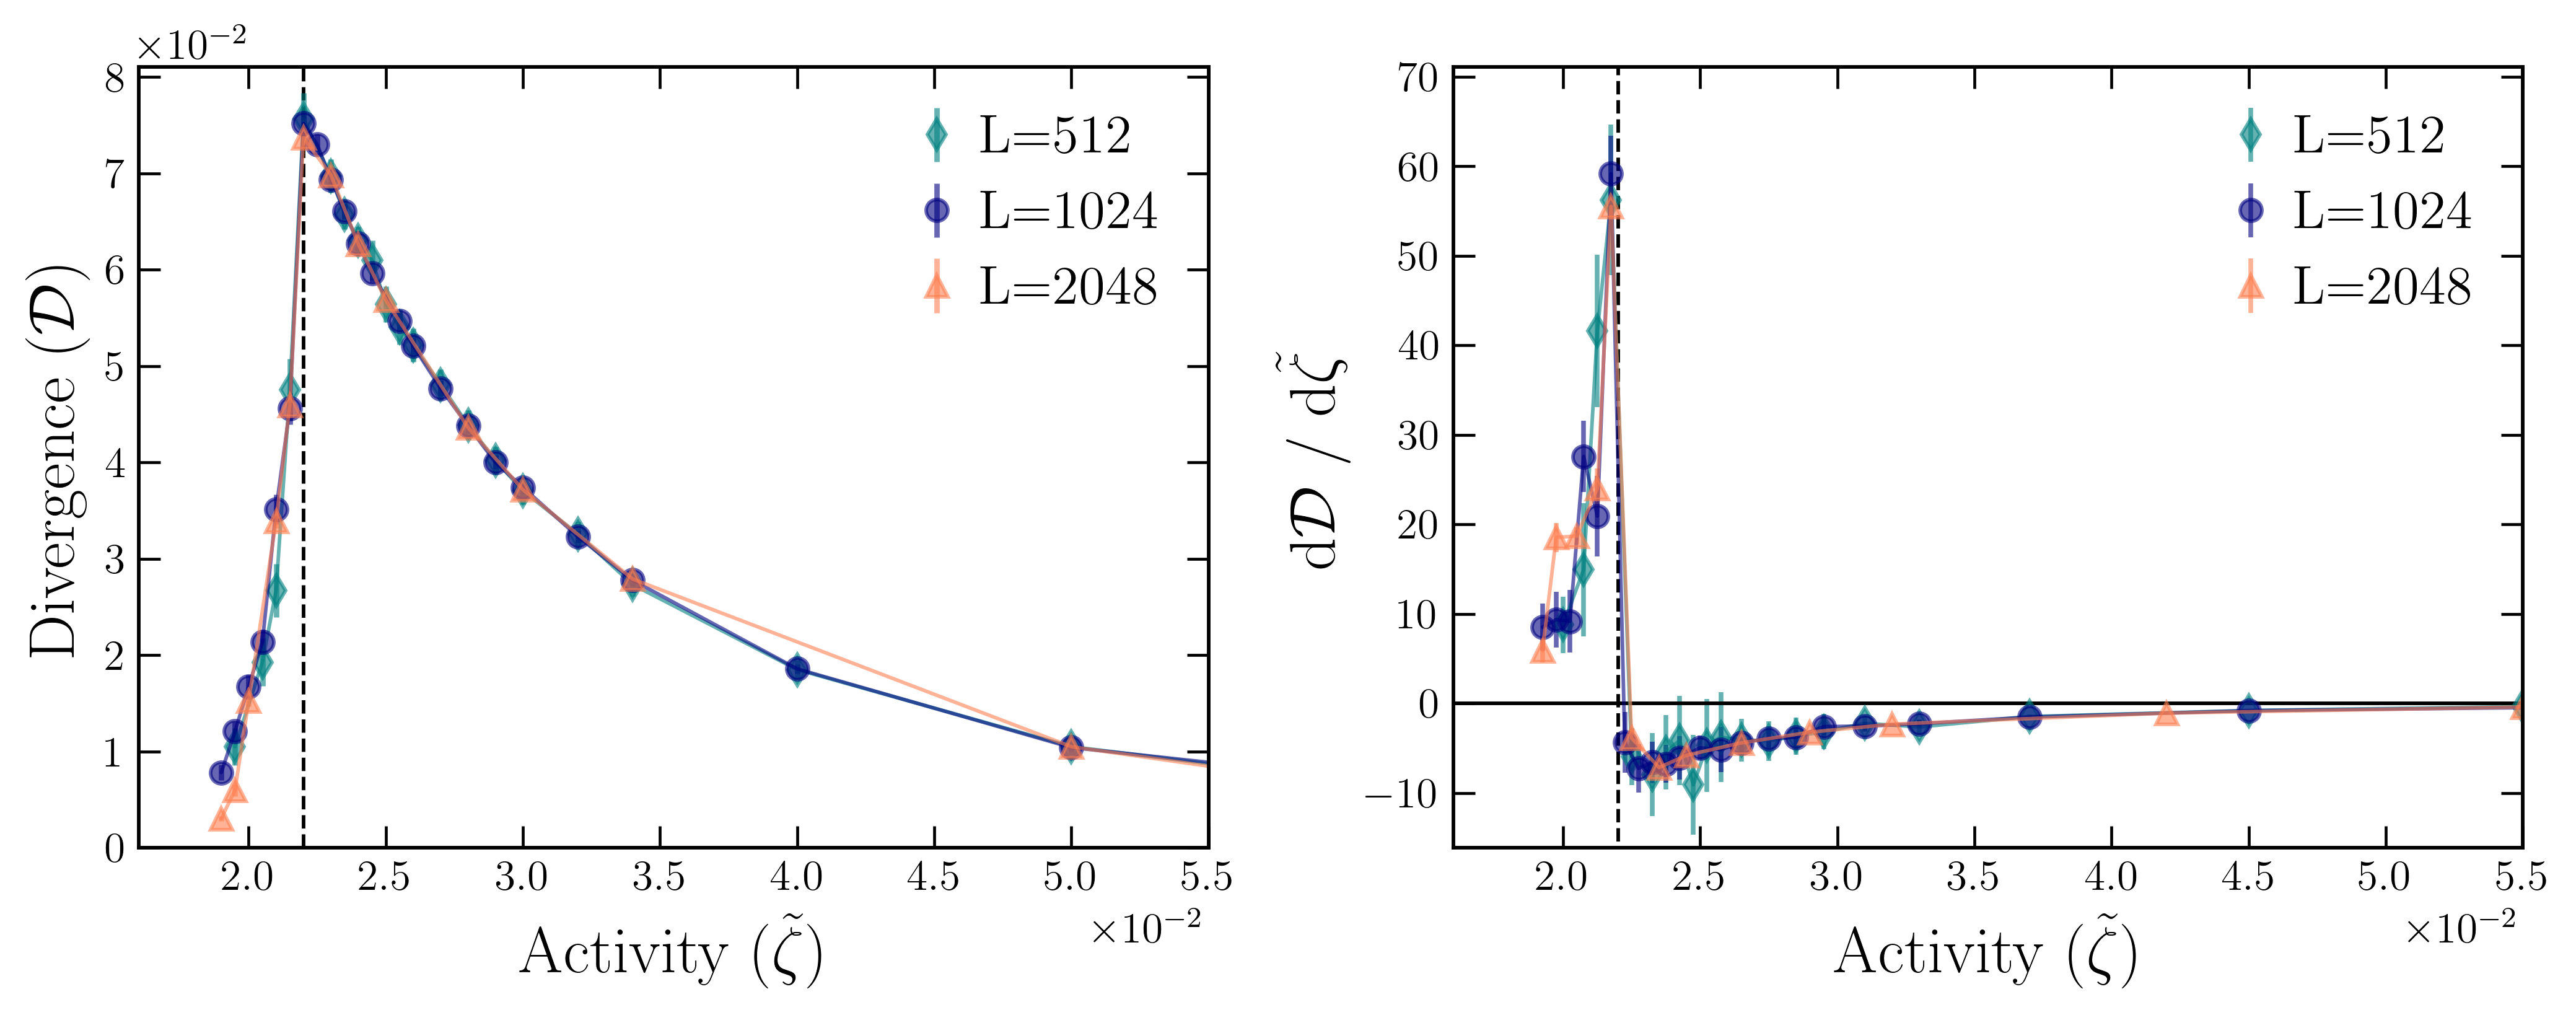

In [78]:

fig, ax0 = plt.subplots(ncols=2, figsize=(10,4))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax = ax0[0]
axx = ax0[1]

plot_div = True
plot_abs = False

xlim = (0.016, 0.055)
ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    frac_diff = np.diff(1 - cid_frac_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_frac = frac_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_frac_err = np.sqrt(cid_frac_time_av[:, 1][1:]**2 + cid_frac_time_av[:,1][:-1]**2) / act_diff

    yvals = 1 - cid_frac_time_av[:,0] if plot_div else cid_frac_time_av[:,0]
    frac_yvals = np.abs(deriv_frac) if plot_abs else deriv_frac

    ax.errorbar(act_list, yvals, yerr=cid_frac_time_av[:,1], fmt=marker_shape[i], lw=1, elinewidth=1.5, label=f'L={LX}', alpha=.6)
    axx.errorbar(act_diff_tot, frac_yvals, yerr=deriv_frac_err, fmt=marker_shape[i], lw=1, elinewidth=1.3, label=f'L={LX}',alpha=.6)

    ymin = min(ymin, np.nanmin(frac_yvals - deriv_frac_err))
    ymax = max(ymax, np.nanmax(frac_yvals + deriv_frac_err))

ax.vlines(0.022, 0, np.nanmax(yvals*1.1), color='k', linestyle='--', lw=1, zorder=-5)
ax.set_ylim(0, np.nanmax(yvals*1.1))

ylabel = r'Divergence ($\mathcal{D}$)' if plot_div else r'CID/CID$_\mathrm{shuffle}$)'
ax.set_ylabel(ylabel) #
ax.legend()

axx.vlines(0.022, ymin*1.2, ymax*1.2, color='k', linestyle='--', lw=1,)
axx.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
axx.set_ylim(ymin*1.1, ymax*1.1)
axx.set_ylabel(r'd$\mathcal{D}$ / d$\tilde{\zeta}$')
axx.legend(ncols=1, loc='upper right')

for i in range(2):
    ax0[i].set_xlim(xlim)
  #  ax0[i].vlines(0.022, 0, np.nanmax(deriv_cid*1.1), color='k', linestyle='--', lw=1,)
    ax0[i].set_xlabel(r'Activity ($\tilde{\zeta}$)')
#axx.set_xlim(xmax=0.045)
if save_figs:
  fig.savefig(os.path.join(figs_save_path, f'div_ddiv.pdf') ,bbox_inches='tight', dpi=620, pad_inches=.05)

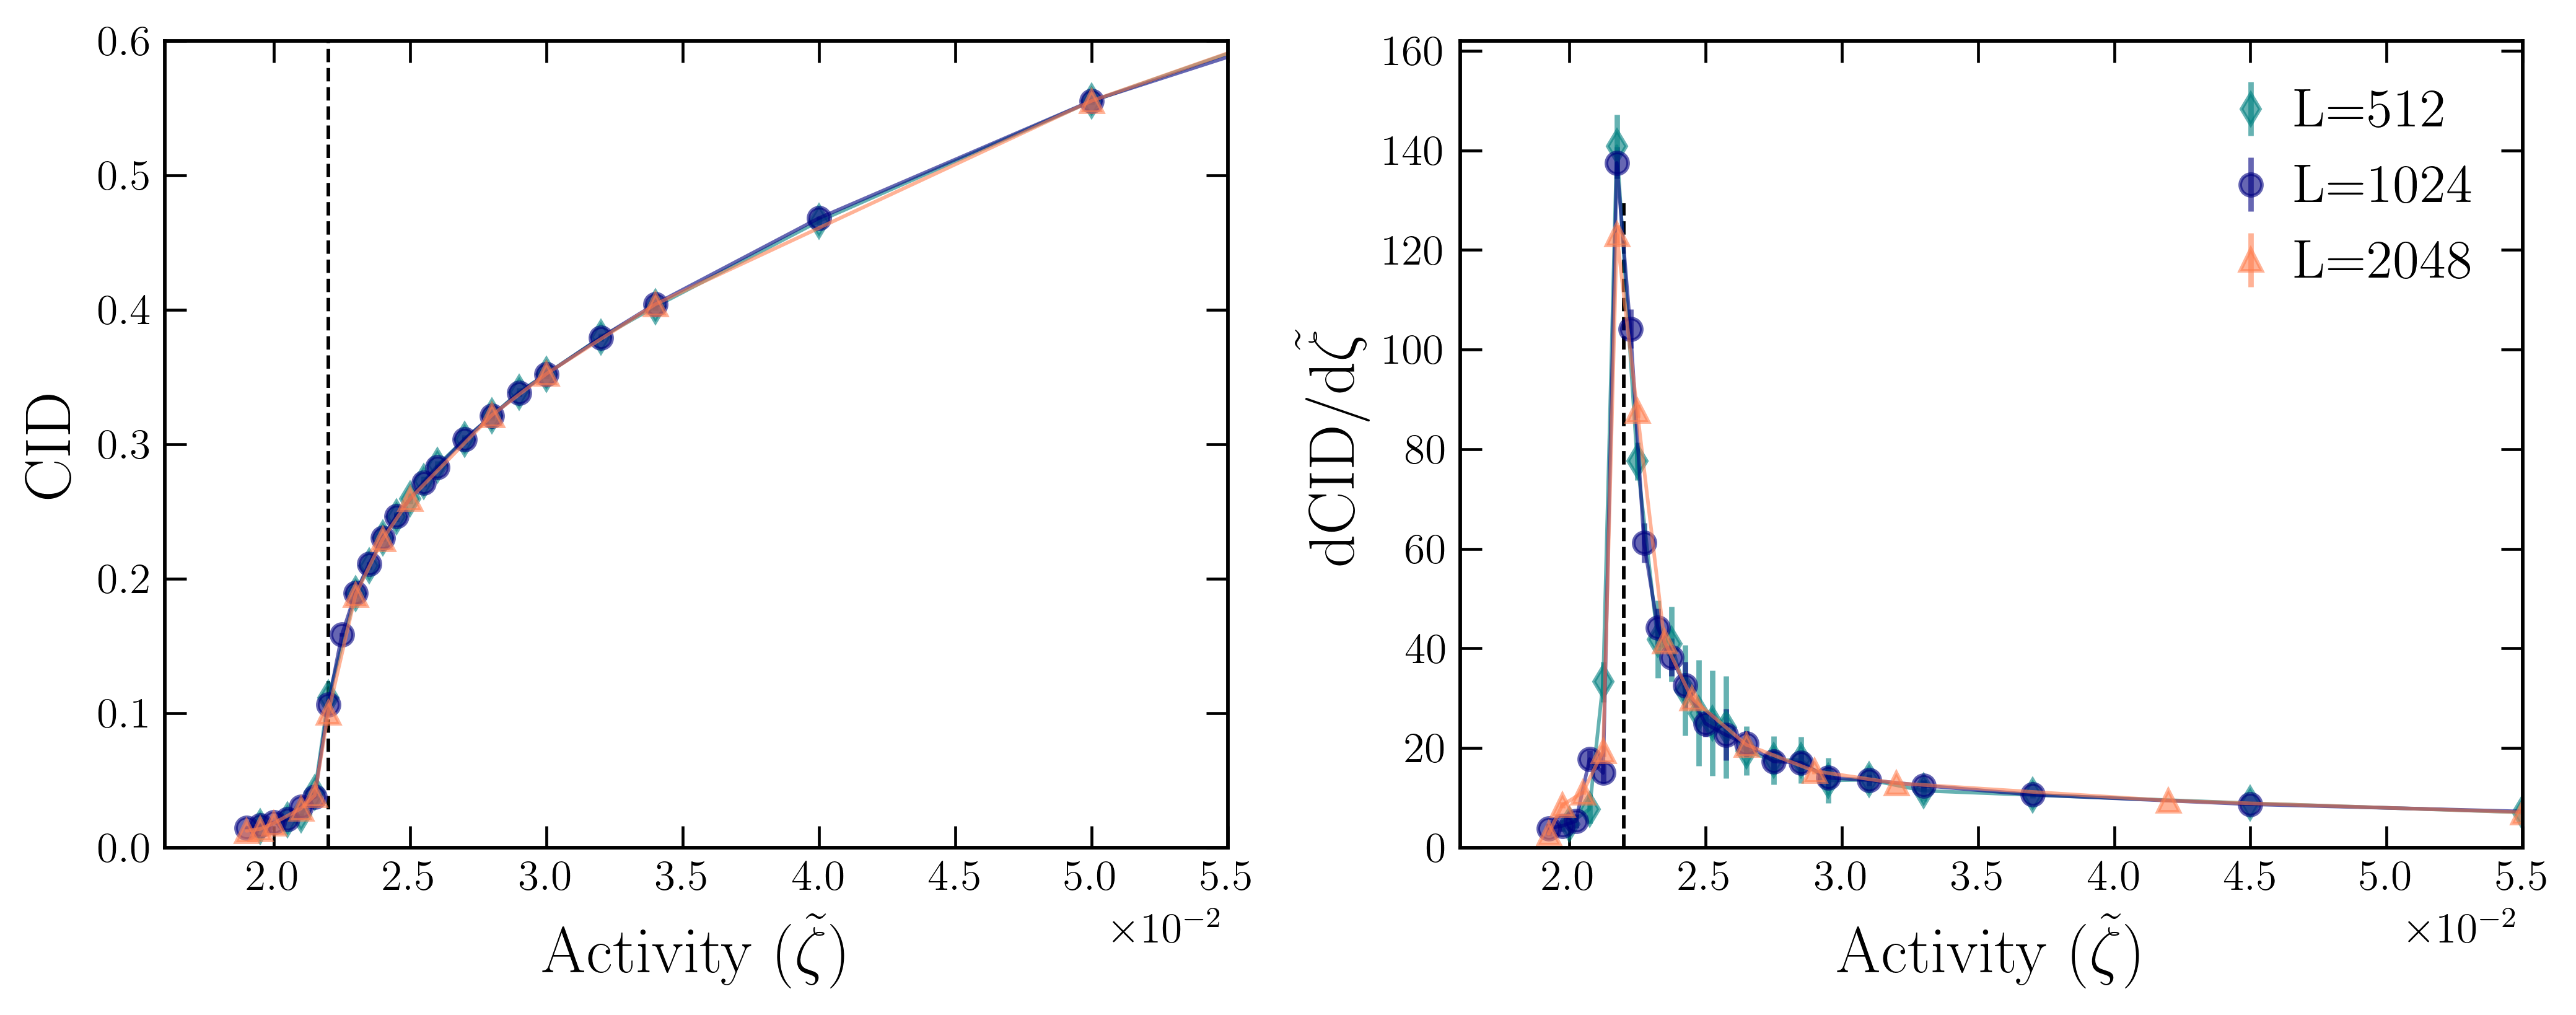

In [74]:
### Plot cid_av vs activity for different system sizes
fig, ax0 = plt.subplots(ncols=2, figsize=(10,4))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

xlim = (0.016, 0.055)
ax = ax0[0]
axx = ax0[1]

ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    cid_diff = np.diff(cid_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    ymin = min(ymin, np.nanmin(deriv_cid - deriv_cid_err))
    ymax = max(ymax, np.nanmax(deriv_cid + deriv_cid_err))

    ax.errorbar(act_list, cid_time_av[:,0], yerr=cid_time_av[:,1], fmt=marker_shape[i], lw=1, label=f'L={LX}', elinewidth=1.5,  alpha=.6)
    axx.errorbar(act_diff_tot, deriv_cid, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', lw=1, elinewidth=1.5, alpha=.6)

for i in range(2):
    ax0[i].set_xlim(xlim)
    ax0[i].vlines(0.022, 0, np.nanmax(deriv_cid*1.05), color='k', linestyle='--', lw=1,)
    ax0[i].set_xlabel(r'Activity ($\tilde{\zeta}$)')

ax.set_ylim(0, 0.6)
ax.set_ylabel(r'CID')
axx.set_ylim(0, np.nanmax(ymax)*1.1)
axx.set_ylabel(r'dCID/d$\tilde{\zeta}$')
axx.legend(ncols=1, loc='upper right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'cid_dcid.pdf'), \
                bbox_inches='tight', dpi=620, pad_inches=.05)

#### Single figs:

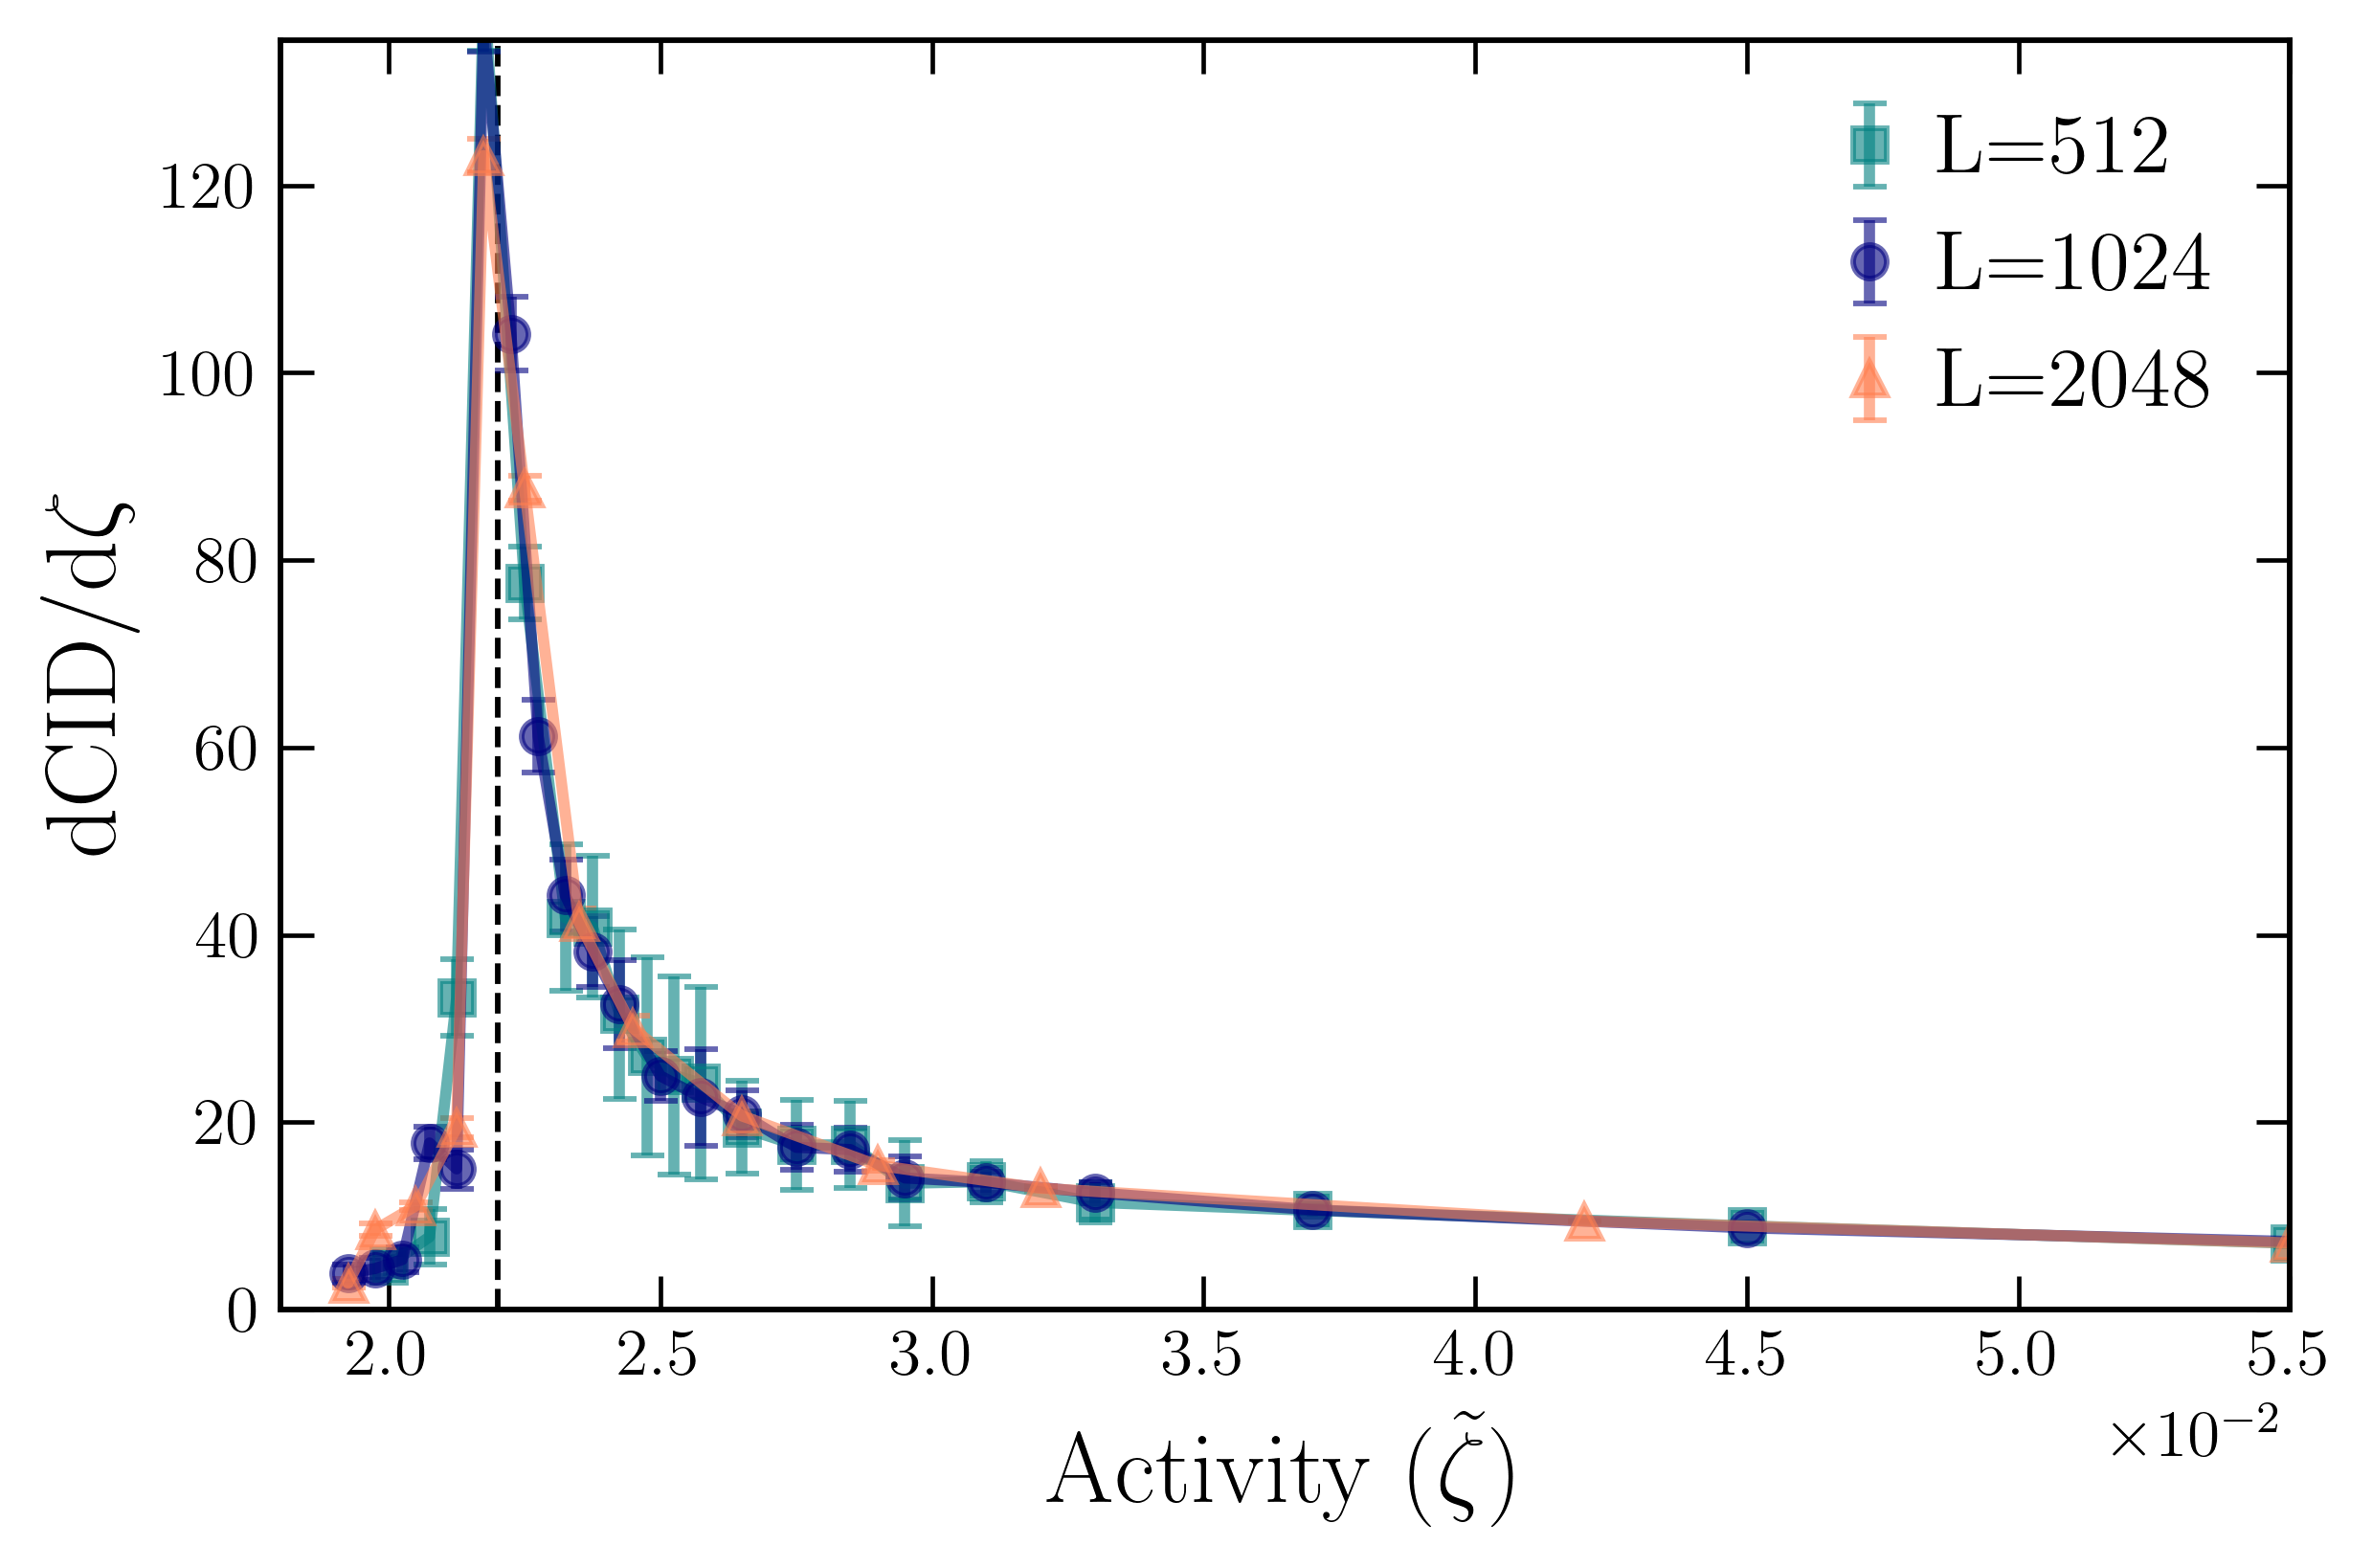

In [75]:
### Plot cid_deriv vs activity for different system sizes
fig, ax = plt.subplots(figsize=(6,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    cid_diff = np.diff(cid_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    ax.errorbar(act_diff_tot, deriv_cid, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

ax.vlines(0.022, 0, np.nanmax(deriv_cid*1.1), color='k', linestyle='--', lw=1, zorder=-5)
ax.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
ax.set_xlim(0.018, 0.055)
ax.set_ylim(ymin=0, ymax=np.nanmax(deriv_cid*1.1))
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ax.set_ylabel(r'dCID/d$\zeta$')
ax.legend(ncols=1, loc='upper right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'dCID.pdf'), bbox_inches='tight', dpi=620, pad_inches=.05)


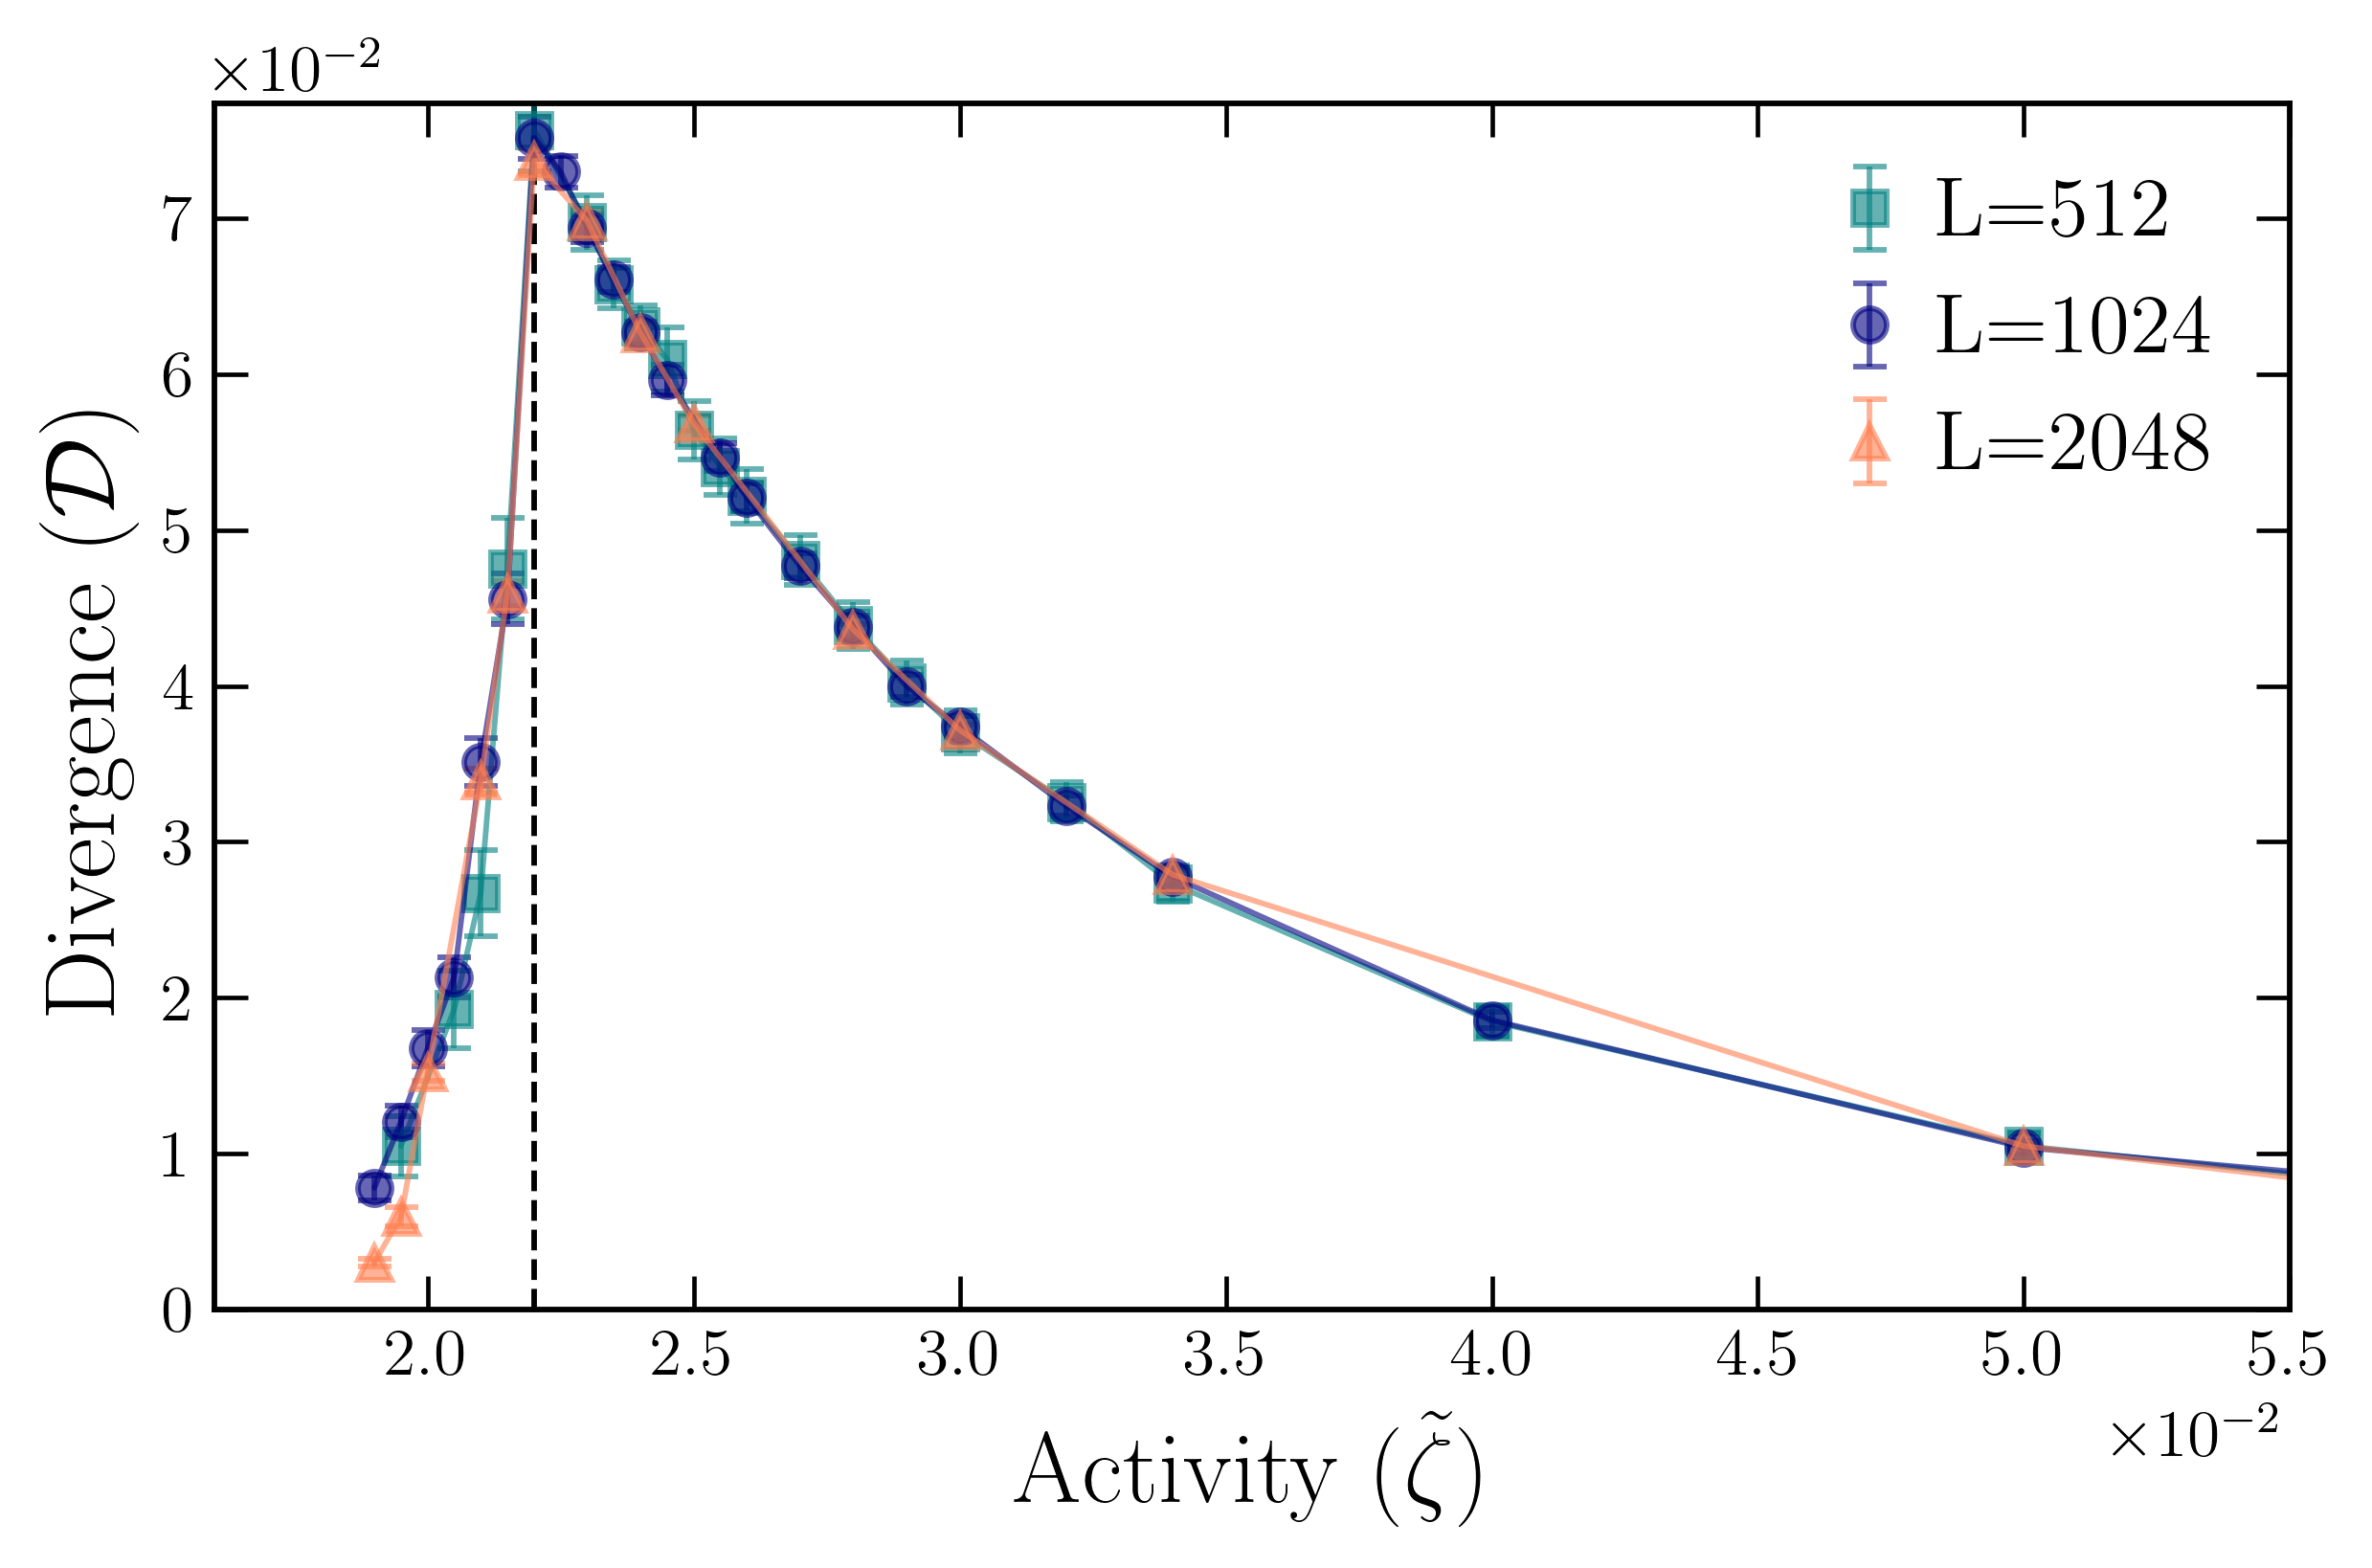

In [76]:
### Plot frac_av vs activity for different system sizes
fig, ax = plt.subplots(figsize=(6,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
plot_div = True

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    yvals = 1 - cid_frac_time_av[:,0] if plot_div else cid_frac_time_av[:,0]

    ax.errorbar(act_list, yvals, yerr=cid_frac_time_av[:,1], fmt=marker_shape[i], lw=1, label=f'L={LX}', capsize=3, alpha=.6)

ax.vlines(0.022, 0, np.nanmax(yvals*1.05), color='k', linestyle='--', lw=1, zorder=-5)
ax.set_xlim(0.016, 0.055)
ax.set_ylim(0, np.nanmax(yvals*1.05))
#ax.set_ylim(np.nanmin(cid_frac_time_av[:,0]*0.95), np.nanmax(cid_frac_time_av[:,0]*1.05))
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ylabel = r'Divergence ($\mathcal{D}$)' if plot_div else r'CID/CID$_\mathrm{shuffle}$)'
ax.set_ylabel(ylabel) #CID/CID$_\mathrm{shuffle}
ax.legend()#loc='lower right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'av_div.pdf'),bbox_inches='tight', dpi=620, pad_inches=.05)

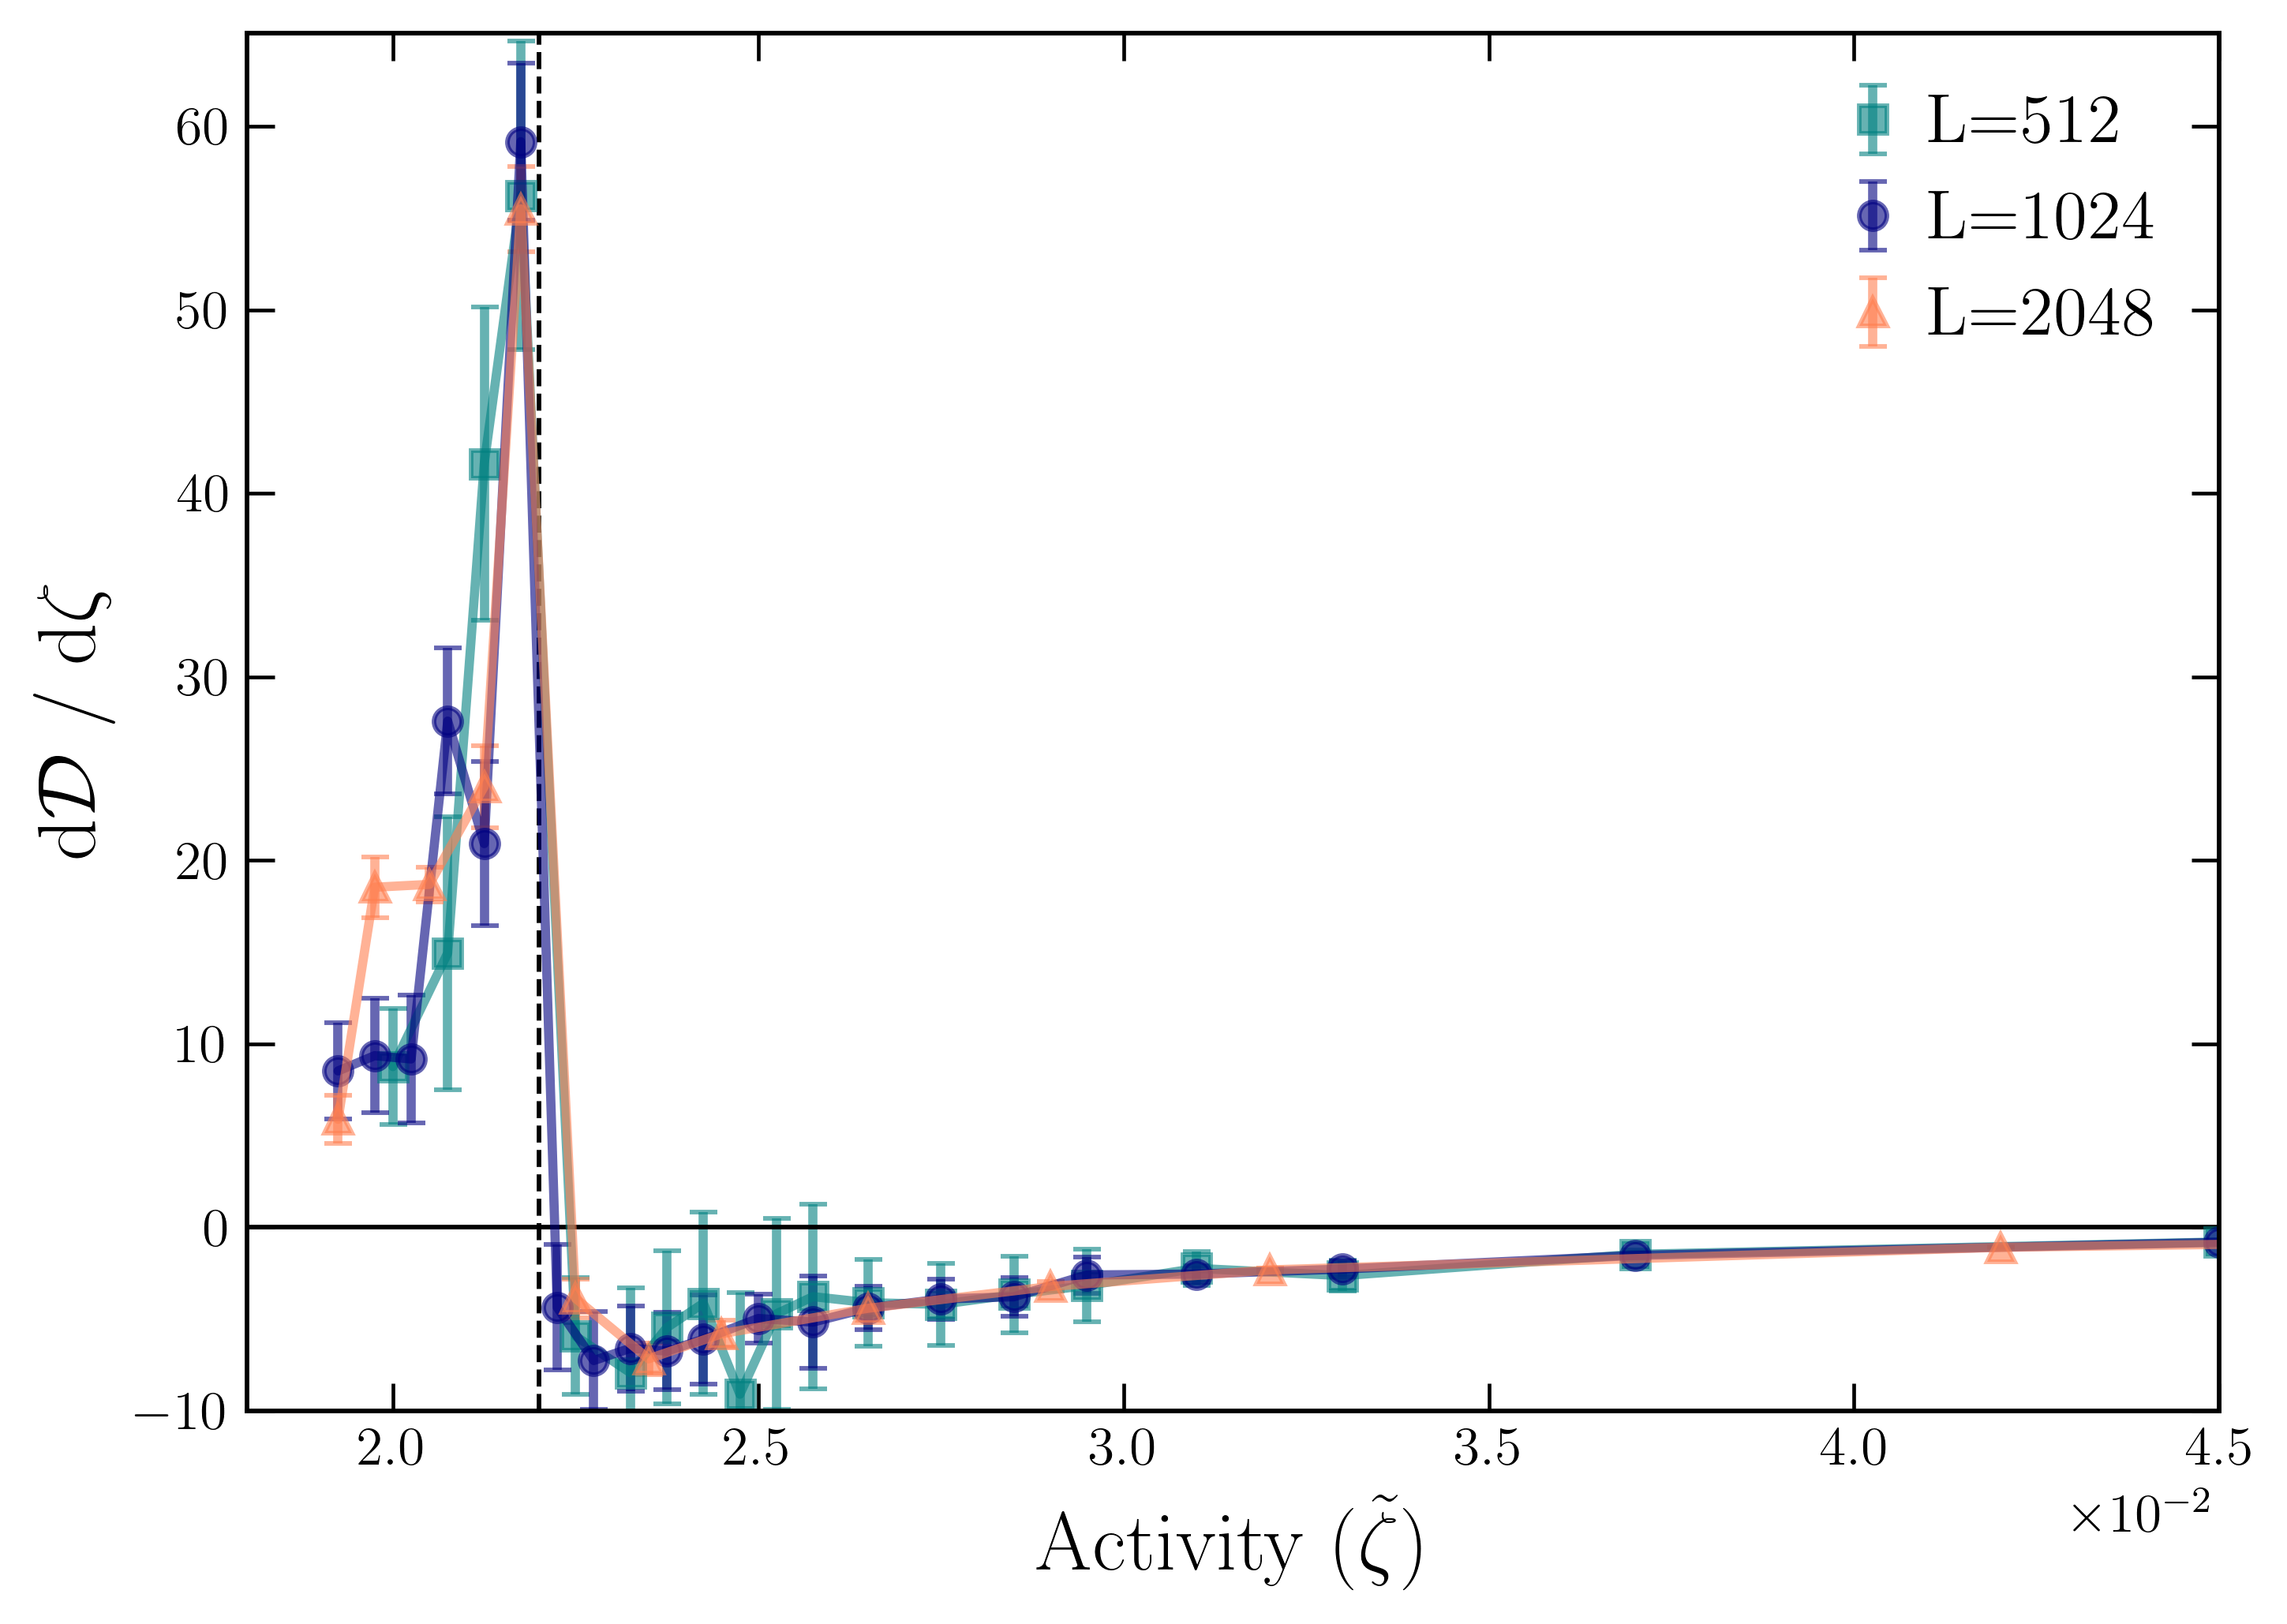

In [77]:
### Plot frac_deriv vs activity for different system sizes
fig, ax = plt.subplots(figsize=(7,5))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
plot_abs = False

ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    frac_diff = np.diff(1 - cid_frac_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_frac = frac_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_frac_err = np.sqrt(cid_frac_time_av[:, 1][1:]**2 + cid_frac_time_av[:,1][:-1]**2) / act_diff

    yvals = np.abs(deriv_frac) if plot_abs else deriv_frac
    ax.errorbar(act_diff_tot, yvals, yerr=deriv_frac_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

    ymin = min(ymin, np.nanmin(yvals))
    ymax = max(ymax, np.nanmax(yvals))

ax.vlines(0.022, ymin*1.1, ymax*1.1, color='k', linestyle='--', lw=1,)
ax.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
ax.set_xlim(0.018, 0.045)
ax.set_ylim(ymin*1.1, ymax*1.1)
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ax.set_ylabel(r'd$\mathcal{D}$ / d$\zeta$')
ax.legend(ncols=1, loc='upper right')

if save_figs:   
    fig.savefig(os.path.join(figs_save_path, f'ddiv.pdf'), bbox_inches='tight', dpi=620, pad_inches=.05)